# Snake AI Game with RL

## Imports

In [ ]:
!pip install imageio
import numpy as np
import matplotlib.pyplot as plt
import imageio
import io
from IPython.display import Image

## Global variables

In [ ]:
DIRECTIONS = ["RIGHT","DOWN", "LEFT", "UP"]
ACTIONS = {
    "STRAIGHT": [1,0,0],
    "RIGHT": [0,1,0],
    "LEFT": [0,0,1]
}

**Note**: `DIRECTIONS` are considered from an external viewpoint (the player's). `ACTIONS` on the other hand are taken from the snake's perspecive. If the snake was going (i.e. had overall orientation) RIGHT and takes as next **action** to keep going RIGHT, its new overall orientation will be DOWN at the following time step.

## Environment

The snake's playground (`grid`) is a 2D array of dimension `(n_rows,n_cols)`.
For a given set of coordinates `(x,y)`, we would access the corresponding point in `grid`, with `grid[x][y]` (as expected). The environment is originally inspired from (https://www.kaggle.com/code/stefancomanita/snake-game-ai-with-reinforcement-learning#The-Trainner), but we overhauled it to fit the data structures we used as inputs to our models.

In [ ]:
class SnakeGameAI:

    def __init__(self,n_rows = 8,n_cols = 8,iteration_max = 100,reward_food = 1,penalty_collision = 0, nb_steps_penalty=20,inactivity_penalty=0,bool_time_penalty=True,reward_type = "standard"):
        #reward_food : reward for eating a fruit
        #penalty_collision : penalty when a collision arises
        #nb_steps_penalty : number of steps without a fruit eaten before a penalty is applied
        #inactivity_penalty : penalty applied after nb_steps_penalty without eating a fruit
        #Attention : pour toute variable écrite, bien la réécrire dans reset
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.iteration_max = iteration_max
        self.reward_food = reward_food
        self.penalty_collision = penalty_collision
        self.nb_steps_penalty=nb_steps_penalty
        self.inactivity_penalty=inactivity_penalty
        self.iterations_without_fruit=0
        self.bool_time_penalty=bool_time_penalty
        self.fruits=0
        self.reward_type = reward_type
        self.reset()

    def reset(self):
        # init game state
        self.direction = "DOWN"
        self.direction_dic={"RIGHT" : 2, "UP" : 3, "LEFT" : 4, "DOWN":5}
        self.iteration = 0
        self.iterations_without_fruit=0
        self.head = (self.n_rows//2, self.n_cols//2)
        self.snake = [self.head,
                      (self.head[0]-1, self.head[1]),
                      (self.head[0]-2, self.head[1])]

        self.score = 0
        self.food = None
        self.place_food()
        self.fruits=0
        self.reset_board()

    def reset_board(self):
        self.board=torch.zeros((2,self.n_rows,self.n_cols),dtype=torch.long)
        self.board[1][self.food]=1
        for (x,y) in self.snake:
          self.board[0][x,y] = 1
        self.board[0][self.head]=-1

    def place_food(self):
        x = np.random.randint(0, self.n_rows)
        y = np.random.randint(0, self.n_cols)
        self.food = (x, y)
        if self.food in self.snake:
            self.place_food()

    def step(self,action): #action in format [straight, right, left]
        self.iteration += 1
        self.iterations_without_fruit+=1
        # 1. move
        x_food, y_food = self.food
        initial_head=self.head
        self.move(action)
        final_head=self.head
        reward = 0
        game_over = False

        # 1 : penalize if the snake doesn't eat fruit for too long
        if self.bool_time_penalty:
          if self.iterations_without_fruit%self.nb_steps_penalty==0:
            reward-=self.inactivity_penalty
            self.score-=self.inactivity_penalty
        # 2. check if game over by collision
        if self.is_collision():
            reward = -self.penalty_collision
            self.score -= self.penalty_collision
            game_over = True

        # 3. check if game finished
        if self.iteration > self.iteration_max:
            game_over = True

        #4. move snake
        if self.head == self.food:
          self.board[1][self.food]=0
          reward = self.reward_food
          self.score += self.reward_food
          self.place_food()
          self.board[1][self.food]=1
          self.iterations_without_fruit=0
          self.fruits=self.fruits+1
        else:
            self.board[0][self.snake[-1]]=0
            self.snake.pop()
            if self.reward_type == "log_dist":
              init_dist_to_food = np.sqrt((initial_head[0]-x_food)**2 + (initial_head[1]-y_food)**2)
              new_dist_to_food = np.sqrt((final_head[0]-x_food)**2 + (final_head[1]-y_food)**2)
              self.score += np.log((len(self.snake)+init_dist_to_food)/(len(self.snake)+new_dist_to_food))/np.log(len(self.snake))


        return reward, game_over, self.score

    def is_collision(self,point = None): #check if snake collides with itself or the wall
        if point is None:
            point = self.head
        if point[0] >= self.n_rows or point[0] < 0:
          return True
        if point[1] >= self.n_cols or point[1] < 0:
          return True
        if point in self.snake[1:]:
          return True

        return False

    def move(self,action): #action  is in format [straigth, right, left]
        current_directions_index = DIRECTIONS.index(self.direction)
        new_direction = self.direction #go straight

        if np.array_equal(action,ACTIONS["RIGHT"]): #change if move right
            new_direction = DIRECTIONS[(current_directions_index + 1)%4]

        elif np.array_equal(action, ACTIONS["LEFT"]): #change if move left
            new_direction = DIRECTIONS[(current_directions_index- 1)%4]

        self.direction = new_direction

        x = self.head[0]
        y = self.head[1]
        if 0<=x<self.n_rows and 0<=y<self.n_cols:
          self.board[0][x,y]=1
        if self.direction == "RIGHT":
            y+= 1
        elif self.direction == "LEFT":
            y-= 1
        elif self.direction == "DOWN":
            x += 1
        elif self.direction == "UP":
            x -= 1
        self.head = (x,y)
        if 0<=x<self.n_rows and 0<=y<self.n_cols:
          self.board[0][x,y]=-1
        if not self.is_collision():
            self.snake.insert(0,self.head)

    def get_grid(self):
        grid = np.zeros((self.n_rows, self.n_cols))
        for (x,y) in self.snake:
            grid[x,y] = 1
        x,y = self.food
        grid[x,y] = 2
        return grid


## Visualizations

In [ ]:
def plot_grid(grid,show=False):
    """
    Plot a single grid frame and return it as an image array.
    - Gray for empty cells (0)
    - Blue for snake cells (1)
    - Red for food cells (2)
    """
    # Define the color map and the normalization
    cmap = plt.cm.colors.ListedColormap(['gray', 'blue', 'red'])
    norm = plt.cm.colors.BoundaryNorm([-1, 0.5, 1.5, 2.5], cmap.N)

    # Plot the grid
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(grid, cmap=cmap, norm=norm,extent=[0,grid.shape[1],0,grid.shape[0]])
    # Remove axes
    # ax.axis('off')
    ax.grid(True)
    if show:
      plt.show()
    # Save the figure to a buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    # Read the image from the buffer and return it
    return imageio.v2.imread(buf)

def grids_to_gif(grids, gif_filename):
    """
    Convert a list of grids into a GIF file.
    """
    images = [plot_grid(grid) for grid in grids]
    imageio.mimsave(gif_filename, images, fps=2)

## Trainer

In [ ]:
from pickle import FALSE
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class QTrainner:

    def __init__(self, model,target, lr, gamma, state_type):
        self.model = model
        self.target=target
        self.lr = lr
        self.gamma = gamma
        self.state_type=state_type
        self.optimizer = optim.Adam(model.parameters(), self.lr)
        self.lossFunction = nn.MSELoss()

    def trainStep(self, state, action, reward, newState, done):
        boolTuple=False
        if self.state_type==2:
          if isinstance(state,tuple):
            boolTuple=True
            stateTensor=torch.stack(state)
            newStateTensor=torch.stack(newState)
          else:
            stateTensor = state
            newStateTensor = newState
        if self.state_type==1:
          stateTensor = torch.tensor(state, dtype=torch.float)
          newStateTensor = torch.tensor(newState, dtype=torch.float)
        actionTensor = torch.tensor(action, dtype=torch.long)
        rewardTensor = torch.tensor(reward, dtype=torch.float)
        if self.state_type==1:
          if len(stateTensor.shape) == 1:
              stateTensor = torch.unsqueeze(stateTensor, 0)
              newStateTensor = torch.unsqueeze(newStateTensor, 0)
              actionTensor = torch.unsqueeze(actionTensor, 0)
              rewardTensor = torch.unsqueeze(rewardTensor, 0)
              done = (done, )
        else:
          if (not boolTuple) and len(stateTensor.shape)==2:
            stateTensor = torch.unsqueeze(stateTensor, 0)
            newStateTensor = torch.unsqueeze(newStateTensor, 0)
            actionTensor = torch.unsqueeze(actionTensor, 0)
            rewardTensor = torch.unsqueeze(rewardTensor, 0)
            done = (done, )
        # 1. predicted q values with current state
        prediction = self.model(stateTensor.to(device))
        current=self.target(newStateTensor.to(device))
        # 2. Q_new = reward + gamma * max(next predicted q value) -> only do this if not done
        target = prediction.clone()
        Y=torch.zeros(len(done))
        Yc=torch.zeros(len(done))
        for i in range(len(done)):
            Qnew = rewardTensor[i]
            if not done[i]:
                Qnew = rewardTensor[i] + self.gamma * torch.max(current[i])
            Y[i]=Qnew
            act=action[i].index(1)
            Yc[i]=prediction[i][act]
        self.optimizer.zero_grad()
        loss = self.lossFunction(Y, Yc)
        loss.backward()

        self.optimizer.step()

## Neural networks

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class LinearQNet(nn.Module):
#Réseau de neurones linéaire classique
    def __init__(self, inputSize, hiddenSize):
        super().__init__()

        self.linear1 = nn.Linear(inputSize, hiddenSize)
        self.linear2 = nn.Linear(hiddenSize, 3)

    def forward(self, X):
        out = self.linear1(X)
        out = F.relu(out)
        out = self.linear2(out)

        return out

class ConvQNet(nn.Module):
#Réseau convolutionnel avec un embedding
    def __init__(self,n_rows,n_cols,embed_dim=3,state_type=1):
        super(ConvQNet, self).__init__()
        self.state_type=state_type
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3), stride=1, padding='same')
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=1, padding='same')
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(6,6), stride=1, padding='same')
        self.dense = nn.Linear(in_features=64*n_rows*n_cols, out_features=256)
        self.dense2 = nn.Linear(in_features=256, out_features=3)
    def forward(self, x):

        if len(x.shape)==2:
          x=torch.unsqueeze(x,0)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.dense(x))
        x=self.dense2(x)

        return x
class ConvQNet2(nn.Module):
#Réseau convolutionnel simplifié sans embedding et avec une couche en moins
    def __init__(self,n_rows,n_cols,hidden_dim=512,nb_channels=16):
        super(ConvQNet2, self).__init__()
        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=nb_channels, kernel_size=(2,2), stride=1, padding='same')
        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=nb_channels, out_channels=nb_channels*2, kernel_size=(2,2), stride=1, padding='same')
        # Define the third convolutional layer
        # Flatten the tensor for the dense layer
        # No specific layer is required for flattening; it will be done in the forward method
        # Define the dense layer
        self.dense1 = nn.Linear(in_features=nb_channels*2*n_rows*n_cols, out_features=hidden_dim)  # Adjust in_features based on the output of the last conv layer
        self.dense2=nn.Linear(in_features=hidden_dim, out_features=3)

    def forward(self, x):
        if len(x.shape)==2:
          x=torch.unsqueeze(torch.unsqueeze(x,0),0)
        if len(x.shape)==3:
          x=torch.unsqueeze(x,1)
        x=x.float()
        # Apply the first convolutional layer followed by ReLU activation function
        x = F.relu(self.conv1(x))
        # Apply the second convolutional layer followed by ReLU activation function
        x = F.relu(self.conv2(x))
        # Flatten the output for the dense layer
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        # Apply the dense layer followed by ReLU activation function
        x = F.relu(self.dense1(x))
        x=self.dense2(x)
        return x
class MLPGrid(nn.Module):
#Réseau convolutionnel simplifié sans embedding et avec une couche en moins
    def __init__(self,n_rows,n_cols):
        super(MLPGrid, self).__init__()
        # Define the first convolutional layer
        self.dense1=nn.Linear(in_features=n_rows*n_cols*2,out_features=512)
        # Define the third convolutional layer
        # Flatten the tensor for the dense layer
        # No specific layer is required for flattening; it will be done in the forward method
        # Define the dense layer
        self.dense2 = nn.Linear(in_features=512, out_features=512)  # Adjust in_features based on the output of the last conv layer
        self.dense3 = nn.Linear(in_features=512, out_features=3)

    def forward(self, x):
        if len(x.shape)==2:
          x=torch.unsqueeze(torch.unsqueeze(x,0),0)
        if len(x.shape)==3:
          x=torch.unsqueeze(x,1)
        x=x.float()
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        # Apply the dense layer followed by ReLU activation function
        x = F.relu(self.dense1(x))
        x=F.relu(self.dense2(x))
        x=self.dense3(x)
        return x

## Deep-Q-Learning Agent

In [ ]:
import torch
import random
import numpy as np
from collections import deque

MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 0.001

class Agent:
    def __init__(self,lr,batch_size,max_mem,gamma,epsilon,target,custom_model=None,state_type=1):
        self.numberOfGames = 0
        # controls randomness
        self.epsilon = epsilon
        # discount rate
        self.gamma = gamma
        self.batch_size=batch_size
        # the last actions, if we reach the limit we will remove the oldest
        self.memory = deque(maxlen=max_mem)
        self.state_type=state_type

        # the modelneeds to have 11 inputs, as our world status grid has 11 elements and the output is 3, as we have 3 directions
        if custom_model is None:
          self.model = LinearQNet(11, 256)
        else:
          self.model=custom_model
        self.target=target
        self.trainner = QTrainner(self.model,self.target, lr=lr, gamma=self.gamma,state_type=state_type)
        self.update_target()

    # this gives us the state of the world
    def update_target(self):
      with torch.no_grad():
        for source_param, target_param in zip(self.model.parameters(), self.target.parameters()):
            target_param.copy_(source_param)
    def getState(self, game):
        head = game.head

        point_left = (head[0] - 1, head[1])
        point_right = (head[0] + 1, head[1])
        point_up = (head[0], head[1] - 1)
        point_down = (head[0], head[1] + 1)

        direction_left = game.direction == "LEFT"
        direction_right = game.direction == "RIGHT"
        direction_up = game.direction == "UP"
        direction_down = game.direction == "DOWN"

        state = [
            # Danger straight
            (direction_right and game.is_collision(point_right)) or
            (direction_left and game.is_collision(point_left)) or
            (direction_up and game.is_collision(point_up)) or
            (direction_down and game.is_collision(point_down)),

            # Danger right
            (direction_up and game.is_collision(point_right)) or
            (direction_down and game.is_collision(point_left)) or
            (direction_left and game.is_collision(point_up)) or
            (direction_right and game.is_collision(point_down)),

            # Danger left
            (direction_down and game.is_collision(point_right)) or
            (direction_up and game.is_collision(point_left)) or
            (direction_right and game.is_collision(point_up)) or
            (direction_left and game.is_collision(point_down)),

            # Move direction
            direction_left,
            direction_right,
            direction_up,
            direction_down,

            # Food location
            game.food[0] < game.head[0],  # food left
            game.food[0] > game.head[0],  # food right
            game.food[1] < game.head[1],  # food up
            game.food[1] > game.head[1]  # food down
        ]

        return np.array(state, dtype=int)
    def getState2(self, game):
      ''' returns the game board with 2 channels:
      - one to locate the snake's body on the grid (-1 for the head, 1 for the body, 0 elsewhere)
      - one to locate the food on the grid (1 for the food, 0 elsewhere)
      '''
      return(game.board)
    def remember(self, state, action, reward, nextState, done):
        self.memory.append((state, action, reward, nextState, done))

    def trainLongMemory(self):
        if len(self.memory) < self.batch_size:
            sample = self.memory
        else:
            sample = random.sample(self.memory, self.batch_size)

        states, actions, rewards, nextStates, dones = zip(*sample)
        self.trainner.trainStep(states, actions, rewards, nextStates, dones)

    def trainShortMemory(self, state, action, reward, nextState, done):
      self.trainner.trainStep(state, action, reward, nextState, done)

    def getAction(self, state,test_loss=False):
        # in the beginning will do some random moves, tradeoff between exploration and exploataition
        finalMove = [0, 0, 0]

        if random.random() < self.epsilon and test_loss==False:
            move = random.randint(0, 2)
            finalMove[move] = 1
        else:
            if self.state_type==1:
              stateTensor = torch.tensor(state,dtype=torch.float)
            if self.state_type==2:
              stateTensor=state
            prediction = self.model(torch.unsqueeze(stateTensor,0).to(device))
            move = torch.argmax(prediction).item()
            finalMove[move] = 1
        return finalMove

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch will train neural networks on {device}")

PyTorch will train neural networks on cuda


## Initialization of the agent

In [ ]:
#Option classique : réseau linéaire, avec état simple (fonction "getState") qui fonctionne environ après 200 jeux
#model1=LinearQNet(11,256).to(device)
#model2=LinearQNet(11,256).to(device)
#agent = Agent(lr=0.001,batch_size=1,max_mem=100_000,gamma=0.95,epsilon=0.2,custom_model=model1,target=model2,state_type=1)
#state=1

#Option plus complexe: réseau convolutionnel (il faut beaucoup d'itérations pour que ça fonctionne)
model1=ConvQNet2(8,8).to(device)
model2=ConvQNet2(8,8).to(device)
agent = Agent(lr=0.001,batch_size=10,max_mem=100_000,gamma=0.95,epsilon=0.8,custom_model=model1,target=model2,state_type=2)
state=2




In [ ]:
import time
# model1=ConvQNet2(8,8).to(device)
# model2=ConvQNet2(8,8).to(device)
# agent = Agent(lr=0.001,batch_size=10,max_mem=100_000,gamma=0.95,epsilon=0.4,custom_model=model1,target=model2,state_type=2)
#Penser bien à reset l'agent en exécutant la cellule au-dessus
scoresHistory = []
meanScores = []
def train(agent,nbepisodes=2000,state_type=1,save_games=True,eval=False,test_loss=False,reward_type = "standard",n_rows=8,n_cols=8):
    totalScore = 0
    bestScore = 0
    game = SnakeGameAI(n_rows=n_rows,n_cols=n_cols,iteration_max=300,reward_type = reward_type)
    grids=[]
    nbsteps=0
    compteur=0
    C=0.9999
    bool=True
    meanScores2=[]
    episodes=[]
    rewards=[]
    episodes_r=[]

    # we train the model for 200 games
    while agent.numberOfGames < nbepisodes:
        if agent.numberOfGames>=5000 and bool:
          game = SnakeGameAI(iteration_max=300)
          bool=False
        nbsteps+=1
        grid=game.get_grid()
        grids.append(grid)
        # get old state
        if state_type==1:
          oldState = agent.getState(game)
        else:
          oldState = agent.getState2(game).to(device)
        # move
        if test_loss:
          finalMove = agent.getAction(oldState,test_loss=True)
        else:
          finalMove = agent.getAction(oldState)
        # perform move and get new state
        reward, done, score = game.step(finalMove)
        if state_type==1:
          newState = agent.getState(game)
        else:
          newState = agent.getState2(game).to(device)

        # train with buffer
        if agent.numberOfGames>5 and agent.numberOfGames%agent.batch_size==0 and not eval:
          agent.trainLongMemory()
        if agent.numberOfGames%50==0 and agent.numberOfGames>1 and not eval:
          agent.update_target()

        # remember
        if state_type==2:
          agent.remember(oldState.to(device), finalMove, reward, newState.to(device), done)
        else:
          agent.remember(oldState, finalMove, reward, newState, done)

        if done:
            compteur+=1
            if save_games:
              print('saving game...')
              gif_filename = 'snake_game_random'+str(agent.numberOfGames+1)+'.gif'
              grids_to_gif(grids, gif_filename)
            agent.numberOfGames += 1

            if score > bestScore:
                bestScore = score

            totalScore += score
            meanScore = (totalScore / compteur)
            if agent.numberOfGames%30==0:
              episodes.append(agent.numberOfGames)
              meanScores2.append(meanScore)
            if agent.numberOfGames % 10 == 0:
              rewards.append(score)
              episodes_r.append(agent.numberOfGames)
            if agent.numberOfGames % 100 == 0:
                print("Game number: ", agent.numberOfGames, "Score: ", score, "Best Score: ", bestScore, "Mean scores: ", meanScore, "Number of steps :", nbsteps,"Fruits :",game.fruits)
                if False and ((score >= bestScore and score >=18) or nbsteps==301):
                  print('saving game...')
                  gif_filename = 'snake_game_random'+str(agent.numberOfGames)+'.gif'
                  grids_to_gif(grids, gif_filename)
                  grids=[]
            nbsteps=0
            grids=[]
            game.reset()
    return(episodes_r,rewards,episodes,meanScores2)

## Test of our optimized agent

In [ ]:
model1=torch.load("model_snake(3).pth")
model2=torch.load("model_snake(3).pth")
agent = Agent(lr=0.001,batch_size=10,max_mem=100_000,gamma=0.95,epsilon=0,custom_model=model1,target=model2,state_type=2)
episode_r, reward, episodes, meanscores = train(agent,nbepisodes = 5000 ,state_type=state,save_games=False,eval=True,reward_type = "standard",n_rows=8,n_cols=8)


Game number:  100 Score:  12 Best Score:  26 Mean scores:  14.32 Number of steps : 83 Fruits : 12
Game number:  200 Score:  14 Best Score:  28 Mean scores:  14.635 Number of steps : 123 Fruits : 14
Game number:  300 Score:  9 Best Score:  28 Mean scores:  14.453333333333333 Number of steps : 64 Fruits : 9
Game number:  400 Score:  13 Best Score:  28 Mean scores:  14.4225 Number of steps : 64 Fruits : 13
Game number:  500 Score:  11 Best Score:  28 Mean scores:  14.494 Number of steps : 92 Fruits : 11
Game number:  600 Score:  14 Best Score:  28 Mean scores:  14.316666666666666 Number of steps : 81 Fruits : 14
Game number:  700 Score:  11 Best Score:  28 Mean scores:  14.255714285714285 Number of steps : 93 Fruits : 11
Game number:  800 Score:  22 Best Score:  28 Mean scores:  14.23875 Number of steps : 138 Fruits : 22
Game number:  900 Score:  19 Best Score:  28 Mean scores:  14.167777777777777 Number of steps : 145 Fruits : 19
Game number:  1000 Score:  15 Best Score:  28 Mean scores:

## Test rewards of our optimized agent

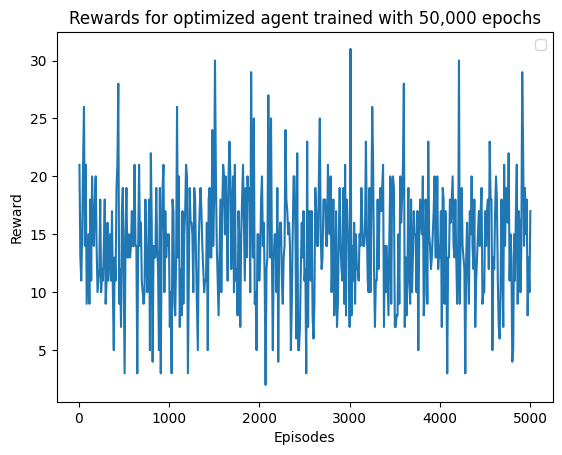

In [ ]:
plt.plot(episode_r, reward)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Rewards for optimized agent trained with 50,000 epochs')
plt.legend()
plt.show()

## Parametrization

Here is the code for the parametrization of our agent with the hidden dimension of our model. Other parametrizations have been done exactly the same way. Running takes around 15-20 minutes with a GPU.

In [ ]:
times=[]
test_scores=[]
for hidden_dim in [128,256,512,1024,2048]:
  model1=ConvQNet2(8,8,hidden_dim=hidden_dim).to(device)
  model2=ConvQNet2(8,8,hidden_dim=hidden_dim).to(device)
  agent = Agent(lr=0.001,batch_size=10,max_mem=100_000,gamma=0.95,epsilon=0.4,custom_model=model1,target=model2,state_type=2)
  state=2
  begin=time.time()
  episodes_r,rewards,episodes,meanScores=train(agent,nbepisodes=4000,state_type=state,save_games=False,eval=False)
  end=time.time()
  times.append(end-begin)
  plt.plot(episodes, meanScores,label="Hidden dimension = "+str(hidden_dim))
plt.xlabel('Episodes')
plt.ylabel('Training mean episode reward')
plt.title('Evolution of the mean score with the number of episodes')
plt.legend()
plt.savefig("compare_plot_hidden_dim.png")


KeyboardInterrupt: 

Here is the code for the parametrization of our agent with the number of channels of our model.

In [ ]:
times2=[]
test_scores=[]
for nb_channels in [4,8,16,32]:
  model1=ConvQNet2(8,8,nb_channels=nb_channels).to(device)
  model2=ConvQNet2(8,8,nb_channels=nb_channels).to(device)
  agent = Agent(lr=0.001,batch_size=10,max_mem=100_000,gamma=0.95,epsilon=0.4,custom_model=model1,target=model2,state_type=2)
  state=2
  begin=time.time()
  episodes_r,rewards,episodes,meanScores=train(agent,nbepisodes=4000,state_type=state,save_games=False,eval=False)
  end=time.time()
  times2.append(end-begin)
  plt.plot(episodes, meanScores,label="Hidden dimension = "+str(hidden_dim))
plt.xlabel('Episodes')
plt.ylabel('Training mean episode reward')
plt.title('Evolution of the mean score with the number of episodes')
plt.legend()
plt.savefig("compare_plot_nb_channels.png")


Game number:  100 Score:  0 Best Score:  1 Mean scores:  0.1 Number of steps : 4 Fruits : 0


KeyboardInterrupt: 

Here is the code for the parametrization of our agent with the $\epsilon$ of the action-selection $\epsilon$-greedy policy

In [ ]:
times=[]
for eps in [0.1,0.2,0.4,0.6,0.8]:
  model1=ConvQNet2(8,8).to(device)
  model2=ConvQNet2(8,8).to(device)
  agent = Agent(lr=0.001,batch_size=10,max_mem=100_000,gamma=0.95,epsilon=eps,custom_model=model1,target=model2,state_type=2)
  state=2
  begin=time.time()
  episodes_r,rewards,episodes,meanScores=train(agent,state_type=state,save_games=False,eval=False,test_loss=True)
  end=time.time()
  times.append(end-begin)
  plt.plot(episodes, meanScores,label="$\\epsilon$ = "+str(eps))
plt.xlabel('Episodes')
plt.ylabel('Training mean episode reward')
plt.title('Evolution of the mean score with the number of episodes')
plt.legend()
plt.savefig("compare_plot_epsilon_test.png")

## Model generalization

In [ ]:
model_modele=torch.load("model_snake(1).pth")
model_modele2=torch.load("model_snake(1).pth")

Initialization of convolutional weights with our 8*8 optimized model

In [ ]:
n_rows=16
n_cols=16
model1=ConvQNet2(n_rows,n_cols).to(device)
model2=ConvQNet2(n_rows,n_cols).to(device)
model1.conv1=model_modele.conv1
model1.conv2=model_modele.conv2
model2.conv1=model_modele2.conv1
model2.conv2=model_modele2.conv2
agent = Agent(lr=0.001,batch_size=10,max_mem=100_000,gamma=0.95,epsilon=0.4,custom_model=model1,target=model2,state_type=2)
episode_r, reward, episodes, meanscores = train(agent,nbepisodes = 5000 ,state_type=state,save_games=False,eval=False,reward_type = "standard",n_rows=n_rows,n_cols=n_cols)


Game number:  100 Score:  1 Best Score:  3 Mean scores:  0.16 Number of steps : 12 Fruits : 1
Game number:  200 Score:  0 Best Score:  3 Mean scores:  0.15 Number of steps : 52 Fruits : 0
Game number:  300 Score:  0 Best Score:  3 Mean scores:  0.16 Number of steps : 10 Fruits : 0
Game number:  400 Score:  0 Best Score:  3 Mean scores:  0.1925 Number of steps : 44 Fruits : 0
Game number:  500 Score:  1 Best Score:  3 Mean scores:  0.218 Number of steps : 18 Fruits : 1
Game number:  600 Score:  0 Best Score:  4 Mean scores:  0.2683333333333333 Number of steps : 101 Fruits : 0
Game number:  700 Score:  0 Best Score:  4 Mean scores:  0.28 Number of steps : 19 Fruits : 0
Game number:  800 Score:  1 Best Score:  4 Mean scores:  0.3 Number of steps : 7 Fruits : 1
Game number:  900 Score:  0 Best Score:  4 Mean scores:  0.3244444444444444 Number of steps : 18 Fruits : 0
Game number:  1000 Score:  0 Best Score:  4 Mean scores:  0.337 Number of steps : 97 Fruits : 0
Game number:  1100 Score:  1

Random initialization of convolutional weights

In [ ]:
n_rows=16
n_cols=16
model1=ConvQNet2(n_rows,n_cols).to(device)
model2=ConvQNet2(n_rows,n_cols).to(device)
agent = Agent(lr=0.001,batch_size=10,max_mem=100_000,gamma=0.95,epsilon=0.4,custom_model=model1,target=model2,state_type=2)
episode_r_std, reward_std, episodes_std, meanscores_std = train(agent,nbepisodes = 5000 ,state_type=state,save_games=False,eval=False,reward_type = "standard",n_rows=n_rows,n_cols=n_cols)


Game number:  100 Score:  0 Best Score:  1 Mean scores:  0.11 Number of steps : 36 Fruits : 0
Game number:  200 Score:  0 Best Score:  2 Mean scores:  0.17 Number of steps : 101 Fruits : 0
Game number:  300 Score:  1 Best Score:  2 Mean scores:  0.15333333333333332 Number of steps : 35 Fruits : 1
Game number:  400 Score:  0 Best Score:  2 Mean scores:  0.145 Number of steps : 10 Fruits : 0
Game number:  500 Score:  0 Best Score:  2 Mean scores:  0.134 Number of steps : 101 Fruits : 0
Game number:  600 Score:  0 Best Score:  2 Mean scores:  0.12833333333333333 Number of steps : 6 Fruits : 0
Game number:  700 Score:  0 Best Score:  2 Mean scores:  0.13857142857142857 Number of steps : 11 Fruits : 0
Game number:  800 Score:  0 Best Score:  2 Mean scores:  0.145 Number of steps : 47 Fruits : 0
Game number:  900 Score:  0 Best Score:  2 Mean scores:  0.14888888888888888 Number of steps : 84 Fruits : 0
Game number:  1000 Score:  0 Best Score:  2 Mean scores:  0.149 Number of steps : 66 Fruit

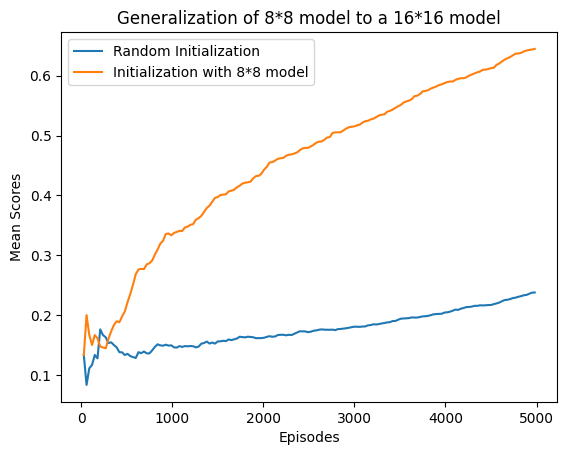

In [ ]:
plt.plot(episodes_std, meanscores_std,label = "Random Initialization")
plt.plot(episodes,meanscores,label = "Initialization with 8*8 model")
plt.xlabel('Episodes')
plt.ylabel('Mean Scores')
plt.title('Generalization of 8*8 model to a 16*16 model')
plt.legend()
plt.show()